In [1]:
from multiprocessing import Pool
import multiprocessing as mp
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from astropy.io import fits
from astropy.table import Table, join
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import spearmanr

from dustmaps.bayestar import BayestarQuery
from dustmaps.vergely2022 import Vergely2022Query
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pickle 
import sys
import os
import tqdm
import datetime

import emcee
import corner

import h5py
from astropy.wcs import WCS

In [2]:
import multiprocessing as mp


In [3]:
from sightline import Sightline

In [4]:
import globalvars
dust_data = globalvars.DustData()

In [5]:
map_fname = '/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/edenhofer_out.h5'

with h5py.File(map_fname, 'r') as f:
    edenhofer = np.array(f['data'])
    dust_data.intake_map(edenhofer)

In [6]:
from specfns import get_wavs, resample_interp, dopplershift, lambda0, sigma0
from filehandling import get_ca_res, get_madgics_res
from spacefns_v2 import select_stars, find_nearest, find_radius, differentialAmplitude
from MCMCfns import logprob_2
import time

In [7]:
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

CA_meta_full = CA_meta.copy()

with open('/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/goodbad.pickle', mode = 'rb') as f:
    goodbad = pickle.load(f)

# added 02.01
data_criteria = (((CA_meta['SNR'] > 80) & (CA_meta['TEFF'] > 5000)) | (CA_meta['SNR'] > 150)) & (CA_meta['ASPCAP_CHI2_1'] > 1) & (CA_meta['ASPCAP_CHI2_1'] < 5)
print(np.sum(data_criteria))
CA_meta= CA_meta[data_criteria]

1010


In [8]:
pathCO = '/uufs/astro.utah.edu/common/home/u1371365/Data/Temporary/Catalogs/DHT21_Taurus_interp.fits'
hdulCO = fits.open(pathCO)

In [9]:
headerCO = hdulCO[0].header
dataCO = hdulCO[0].data
wcsCO = WCS(headerCO)
headerCO

SIMPLE  =                    T  / Standard FITS format                          
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    3  / Number of axes                                
NAXIS1  =                   81  / Number pixels on axis 1                       
NAXIS2  =                  307  / Number pixels on axis 2                       
NAXIS3  =                  213  / Number pixels on axis 3                       
CTYPE1  = 'VELO-LSR'            / axis 1 coord type                             
CRVAL1  =        -2.178010E+01  / coord value at CRPIX1                         
CDELT1  =         6.501900E-01  / linear pixel spacing axis 1                   
CRPIX1  =             1.000000  / ref pixel for axis 1                          
CTYPE2  = 'GLON-CAR'            / axis 2 coord type                             
CRVAL2  =         1.912500E+02  / coord value at CRPIX2                         
CDELT2  =        -1.250000E-

In [10]:
glon = headerCO['CRVAL2'] + headerCO['CDELT2'] * (np.arange(0, headerCO['NAXIS2'])- headerCO['CRPIX2'])
glat = headerCO['CRVAL3'] + headerCO['CDELT3'] * (np.arange(0, headerCO['NAXIS3'])- headerCO['CRPIX3'])
rvel = headerCO['CRVAL1'] + headerCO['CDELT1'] * (np.arange(0, headerCO['NAXIS1'])- headerCO['CRPIX1'])

In [11]:
l, b, v = np.meshgrid(glon, glat, rvel)
# coord_gal = SkyCoord(l = l * u.deg, b =b * u.deg, frame = 'galactic')
# ra, dec = (coord_gal.transform_to('icrs').ra.value, coord_gal.transform_to('icrs').dec.value)
# coord_lsr = SkyCoord(ra * u.deg, dec * u.deg, radial_velocity = v * u.km/u.s, frame = 'lsr')
coord = SkyCoord(l * u.deg, b  * u.deg, radial_velocity = v * u.km/u.s, pm_l_cosb = 0 * u.deg/u.s,
                  pm_b = 0 * u.deg /u.s, distance = 500 * u.pc, frame = 'galacticlsr')

In [12]:
coord_icrs = coord.transform_to('icrs')

In [13]:
spec, cel = wcsCO.pixel_to_world(0, 0, 0) # velocity, 
print(cel)
print(spec)
wcsCO.world_to_pixel(0 * u.km/u.s, cel)

<SkyCoord (Galactic): (l, b) in deg
    (191.25, -28.5)>
-21.7801 m / s


(array(33.49805441), array(0.), array(0.))

In [14]:
wcsCO.world_to_pixel(cel, spec)

(array(0.), array(0.), array(0.))

In [15]:
print(dataCO.T.shape)

(81, 307, 213)


In [16]:
coord_icrs.T.shape

(81, 307, 213)

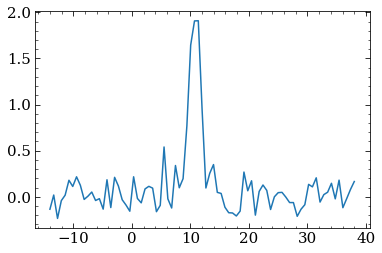

In [17]:
def get_CO_profile(l, b):
    coord_sel = SkyCoord(l = l * u.deg, b = b * u.deg, frame = 'galactic')
    pix_ind_l, pix_ind_b = wcsCO.world_to_pixel(0 * u.km/u.s, coord_sel)[1:]
    CO_profile = dataCO.T[:, int(pix_ind_l), int(pix_ind_b)]
    rvel = coord_icrs.T.radial_velocity[:, int(pix_ind_l), int(pix_ind_b)]
    return CO_profile, rvel
profile, rvel = get_CO_profile(165, -7)

plt.plot(rvel, profile)

In [18]:
# fig = plt.figure()
# ax = plt.subplot(projection = wcsCO.celestial) 
# ax.imshow(np.nansum(dataCO, axis = 2), cmap = 'binary', origin = 'lower')



In [19]:
from astropy.coordinates import LSR


In [20]:
wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
wavs_window = wavs[window]

In [21]:
ds = 2.5 # x downsampled
rad = 0.23
sample_dim_l = np.linspace(159, 167, int(8 / (ds * rad)))
sample_dim_b = np.linspace(-12.5 , -4.5, int(8 / (ds * rad)))
sample_grid_l, sample_grid_b = np.meshgrid(sample_dim_l, sample_dim_b)
grid_map_inds = np.array([find_nearest(sample_grid_l.flatten()[i], sample_grid_b.flatten()[i]) for i in range(len(sample_grid_l.flatten()))]).T
grid_map = np.nansum(np.copy(edenhofer[grid_map_inds[1], grid_map_inds[0], :]).reshape(*sample_grid_l.shape, -1), axis = 2)
grid_Nstar = np.array([np.nansum((np.abs((sample_grid_l.flatten()[i] - CA_meta['GLON'])) <= rad) & 
            (np.abs((sample_grid_b.flatten()[i] - CA_meta['GLAT'])) <= rad)) for i in range(len(sample_grid_l.flatten()))]).reshape(*sample_grid_l.shape)

filament_l = (159, 169)
filament_b = (-10, -6)

N_min = 5
radius_min = np.zeros(sample_grid_l.shape)
mgrid = np.mgrid[0:len(sample_dim_l), 0:len(sample_dim_b)]
for i in mgrid[0].flatten():
    for j in mgrid[1].flatten():
        radius_min[i, j] = find_radius(sample_grid_l[i, j], sample_grid_b[i, j], N_min, CA_meta)
        radius_min[i, j] = np.max([radius_min[i, j], 0.23])

radius_max = 0.4
print(np.nansum(radius_min < radius_max))


crit_filament = ((sample_grid_l > filament_l[0]) & (sample_grid_l < filament_l[1]) & 
                 (sample_grid_b > filament_b[0]) & (sample_grid_b < filament_b[1]) &
                 (grid_map > 2.2) & (radius_min < 0.5)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

crit_background =  (((sample_grid_l <= filament_l[0]) | (sample_grid_l >= filament_l[1]) |
                 (sample_grid_b <= filament_b[0]) | (sample_grid_b >= filament_b[1])) &
                 (grid_map <= 1.5) & (radius_min < radius_max)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

# crit_coverage = (np.sum() => 1 & )

N_filament = np.sum(crit_filament)
N_background = np.sum(crit_background)
print(np.sum(crit_filament))
print(np.sum(crit_background))
l_fil, b_fil, AV_fil = (sample_grid_l[crit_filament].flatten(), sample_grid_b[crit_filament].flatten(),
                        grid_map[crit_filament].flatten())
l_off, b_off, AV_off = (sample_grid_l[crit_background].flatten(), sample_grid_b[crit_background].flatten(),
                        grid_map[crit_background].flatten())

l_sample, b_sample, AV_sample = (np.concatenate([l_fil, l_off]), np.concatenate([b_fil, b_off]),
                                  np.concatenate([AV_fil, AV_off]))
radius_min_fil = radius_min[crit_filament].flatten()
radius_min_off = radius_min[crit_background].flatten()
radius_sample = np.concatenate([radius_min_fil, radius_min_off])

selected_inds = []
for i in range(len(l_sample)):
    l_center, b_center = l_sample[i], b_sample[i]
    rad_i = radius_sample[i]
    selection = select_stars(CA_meta, l_center, b_center, radius = rad_i)
    # print(len(selection))
    selected_inds.append(selection)

91
23
28


In [22]:
dist = np.array([350, 401, 450, 500])
print(np.insert(np.delete(dist, np.where(dist <=0)[0]), [0, 1], [0, 400]))

[  0 350 400 401 450 500]


In [23]:
class ForegroundModifiedSightline(Sightline):
    def __init__(self, stars, coords = None, dAVdd = None, dfore = 400, **kwargs):
        # self.all_stars = stars
        self.stars = stars[stars['DIST'] > dfore]
        dist = self.stars['DIST']

        self.make_fgbins()
        self.bin_inds = np.digitize(dist, self.bins)

        if coords is not None:
            self.l, self.b = coords
        else:
            self.l, self.b = (np.nanmean(self.stars['GLON']), np.nanmean(self.stars['GLAT']))
        
        self.rvelo = np.zeros(len(self.bins) - 1)
        self.get_DIBs(**kwargs)

        # self.init_signals = self.model_signals(self.rvelo, self.dAVdd)
        self.ndim = len(self.voxel_dAVdd)
        self.nsig = len(self.stars)

        self.test_init_signals = self.model_signals_fg(self.rvelo, self.dAVdd)

    def make_fgbins(self, binsep = 10, dfore = 400, **kwargs):
        dmin = 0 # start bins at 0pc
        dist = self.stars['DIST']
        bins = np.sort(np.insert(np.delete(dist, np.where(dist <= dmin)[0]), [0,1], [dmin, dfore]))
        # print('BINS BEFORE THING', bins)
        i = 0
        while i >= 0:
            try:
                next_bin = np.min(bins[bins > bins[i]])
            except:
                print('broke:')
                print(bins[bins > bins[i]])
                print(len(self.stars))

            bins[i+1] = np.max([next_bin, bins[i] + binsep]) + 0.01
            if bins[i+1] >= np.max(dist):
                bins = bins[:i+2]
                i = -np.inf
            i = i+1
        
        self.bins = bins

    def model_signals_fg(self, rvelo, dAVdd=None, binsep = None):
        if dAVdd is None:
            dAVdd = self.dAVdd
        if binsep is None:
            binsep = self.bins[1:]-self.bins[:-1]
        signals = np.zeros((len(self.stars), len(wavs_window)))
        peak_wavelength = dopplershift(rvelo)
        wavs_grid = np.tile(wavs_window, (len(self.bins)-1, 1))
        voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
        amp = differentialAmplitude(dAVdd, binsep)

        def single_signal(amp, bindex):
            amp[bindex :] = 0 # THIS MIGHT NEED TO BE -1

            voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
            summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
            # continuum = lambda x, m, b : m * (x - lambda0) + b
            # cont = continuum(wavs_window, 0, b)
            return summed_DIB  + 1


        for i in range(len(self.stars)):
            star = self.stars[i]
            dAVdd_star = dAVdd[i, :]
            # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
            amp = differentialAmplitude(dAVdd_star, 1)

            bin_index = self.bin_inds[i]
            # signals[i, :] = single_signal(bin_index)
            signals[i, :] = single_signal(amp, bin_index)
        return signals



In [24]:
# model = ForegroundModifiedSightline(stars, dustdata = dust_data)

In [25]:
sightlines = []
for i in range(len(selected_inds)):
    sightlines.append(ForegroundModifiedSightline(CA_meta[selected_inds[i]], dustdata = dust_data))

/uufs/astro.utah.edu/common/home/u1371365/nanoKT_v1/residual_process.py:7: RuntimeWarning: invalid value encountered in true_divide
  res = hdu_rf[0, :] / hdu_rf[2, :]
/uufs/astro.utah.edu/common/home/u1371365/nanoKT_v1/residual_process.py:8: RuntimeWarning: divide by zero encountered in true_divide
  res_corr = res / hdu_rf[4, :]


In [26]:
sightlines = sightlines[:10]

In [27]:
# def logprob_2(p, sl, logprior = logprior_v, loglikely = loglikely_2, **kwargs):
#     ndim = len(sl.voxel_dAVdd)
#     v = p[ :ndim]
#     av = p[ndim:].reshape(-1, ndim)

#     # print(av.shape)

#     lp = logprior(v, **kwargs)
#     lp_davdd = logprior_davdd(av, AV_base = sl.dAVdd)
#     lp_davdd_reg = logprior_davdd_reg(av, sl, **kwargs)
#     lp_davdd_reg_group = logprior_davdd_reg_group(av, sl)

#     if (not np.isfinite(lp)) | (not np.isfinite(lp_davdd)) | (not np.isfinite(lp_davdd_reg)):
#         # print('fail logprob')
#         return -np.inf
#     return lp + lp_davdd + lp_davdd_reg +  loglikely_2(v, av, sl = sl, **kwargs) + lp_davdd_reg_group # group term added 10.13

In [28]:
class Logprior_Foreground:
    def __init__(self, l, b):
        self.pointfit = self.polynomial2d(l, b)
        self.pointfit_width = 2.404363059339516

    def polynomial2d(self, x1, x2, theta = None, uncert = None):  
        if theta is None:
            theta = np.array([5.03964666, -1.04129592, -0.72842925, -0.20292219,  0.0206567,  -0.14442016])
        if uncert is None:
            uncert = 2.404363059339516
        if np.array(x1).ndim != 1:
            x1 = np.array([x1])
            x2 = np.array([x2])
        x1 = x1 - 160 # FOR CA CLOUD SPECIFICIALLY
        x2 = x2 + 8 # DITTO
        X = np.array([[np.ones(np.array(x1).shape), x1, x2, x1 * x2, x1**2, x2**2]]).T
        matrix = X * theta[:, np.newaxis]
        return np.nansum(matrix, axis =1).item()
    
    def logprior_foreground_v(self, v, distance, foreground_distance = 401, **kwargs):    
        foreground = distance <= foreground_distance
        prior_val = np.zeros(distance.shape)

        prior_val[foreground] = (- 0.5 * (v - self.pointfit)**2 / (self.pointfit_width**2))[foreground]
        return np.nansum(prior_val)
        
    def logprior_foreground_av(self, av, distance, foreground_distance = 400):
        foreground = distance <= foreground_distance
        prior_val = np.zeros(distance.shape)
        ampfit = (0.01928233, 0.01431857)
        avf = lambda x, mu, sigma :  -(x - mu)**2 / (2 * sigma**2)
        prior_val[foreground] = - 0.5 * np.nansum((av - ampfit[0])**2 / (ampfit[1]**2))[foreground]
        return np.nansum(prior_val)


In [29]:
from MCMCfns import logprob_2#, Logprior_Foreground


def logprob_fg(p, sl, lp_fore = None, **kwargs):
    ndim = len(sl.voxel_dAVdd)
    
    lprob = logprob_2(p, sl, **kwargs)
    v = p[ :ndim]
    av = p[ndim:].reshape(-1, ndim)

    lp_fore_v = lp_fore.logprior_foreground_v(v, sl.bins[1:])
    # lp_fore_av = lp_fore.logprior_foreground_av(av, sl.bins[1:])
    return lprob + lp_fore_v #+ lp_fore_av






def MCMC_fg(sl, steps = 1000, nwalkers = 100, pool = None):
    ndim = len(sl.voxel_dAVdd) 
    nstar = len(sl.stars)
    ndim_amp = int(ndim + ndim * nstar)

    lp_foreground = Logprior_Foreground(sl.l, sl.b)

    

    # dAVdd_prior = sl.dAVdd[:]
    # dAVdd_prior[dAVdd_prior == 0] = np.nan 
    # dAVdd_prior_med = np.nanmedian(dAVdd_prior, axis = 1)
    # dAVdd_prior_std = np.nanstd(dAVdd_prior, axis = 1, ddof = 1)
    # gaussparams = (dAVdd_prior_med, dAVdd_prior_std)
    # print(gaussparams)

    # with Pool(15) as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_fg, 
                                    kwargs={'sl': sl, 'lp_fore': lp_foreground}, pool = pool) # OKAY SO I FORGOT TO CHANGE THIS, WAS LOGPROB_2
    # init = 12.5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
    init = 10 *  (np.random.random((nwalkers, ndim_amp)) - 0.5)

    init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
    print('NDIM:', ndim, 'NSTAR:', nstar, 'INITSHAPE:', init.shape)
    
    sampler.run_mcmc(init,  steps, progress = True);
    
    return sampler, ndim, ndim_amp

In [30]:
# sl.dAVdd_mask

In [31]:
sl = sightlines[0]
ndim = len(sl.voxel_dAVdd) 
nstar = len(sl.stars)
ndim_amp = int(ndim + ndim * nstar)
lp_foreground = Logprior_Foreground(sl.l, sl.b)
# lp_foreground.logprior_foreground_v(10, 400)

In [32]:
init = 10 *  (np.random.random((500, ndim_amp)) - 0.5)
# print(init.shape[0, :])
print(logprob_fg(init[5, :], sl, lp_fore = lp_foreground,))

-inf


In [33]:
stp = 1500
# sampler, ndim, ndim_amp = MCMC_scary(a, steps = stp, nwalkers = 500)
# sTHIsTThisterasdfdsfafsdfsdafampler1, ndim1, ndim_amp1 = MCMC(a1, steps = stp)
# sampler2, ndim2, ndim_amp2 = MCMC(a2, steps = stp)
# sampler3, ndim3, ndim_amp3 = MCMC(a3, steps = stp)

if False:
    today = str(datetime.date.today()).split('-')
    datelabel = today[1]+today[2]
    run_label = 'kt_' + datelabel + 'c'
else:
    run_label = 'kt_0331c'

save_individual = False

first_run = True



if first_run:
    if not os.path.exists(os.getcwd() + '/RUNS_FG/' + run_label):
        os.makedirs(os.getcwd() +'/RUNS_FG/' + run_label)
        inp = input('Please describe this run:')
        with open('/RUNS_FG/global_log.txt', mode = 'a') as global_log:
            global_log.write('-------------------------------------------- \n')
            global_log.write(run_label)
            global_log.write(inp + '\n \n')
    with Pool(10) as pool:
        for i in range(len(sightlines)):
            # try:
            if True:
                sl_i = sightlines[i]
                smplr, ndm, ndm_amp = MCMC_fg(sl_i, steps = stp, nwalkers = 500, pool = pool)
                # smplr_array.append(smplr)
                # mid = time.time()
                # print('Time mid - start', mid - start) # beat 7:22
                # smplr_, ndim_ = MCMC_vonly(sl_i, smplr, steps = 1200, nwalkers = 100, pool = None)
                # end = time.time()
                # print('Time end - start:',(end - start)/60)
                
                sl_i.intake(smplr)
                state = 'success'
            # except Exception as e:
            #     print('Something went wrong')
            #     sl_i = None 
            #     state = 'fail'
            #     with open('RUNS_FG/' + run_label + '/FAILS.txt', mode = 'a') as fails:
            #         fails.write(str(e))
                
            with open('RUNS_FG/' + run_label + '/LOG.txt', mode = 'a') as log:
                logstring = time.asctime() + ' | ' + str(i) + ' | ' + state + '\n'
                log.write(logstring)
            
            if save_individual == True:
                with open('RUNS_FG/' + run_label + '/sl_{}.pickle'.format(i), mode = 'wb') as f:
                    pickle.dump(sl_i, f)


NDIM: 5 NSTAR: 4 INITSHAPE: (500, 25)


100%|██████████| 1500/1500 [02:42<00:00,  9.25it/s]


NDIM: 6 NSTAR: 5 INITSHAPE: (500, 36)


100%|██████████| 1500/1500 [02:40<00:00,  9.36it/s]


NDIM: 6 NSTAR: 5 INITSHAPE: (500, 36)


100%|██████████| 1500/1500 [02:42<00:00,  9.25it/s]


NDIM: 6 NSTAR: 5 INITSHAPE: (500, 36)


 21%|██        | 310/1500 [00:34<02:12,  9.01it/s]

In [ ]:

# sightlines[0].sampler.chain

In [ ]:
name = run_label

# first_run = False

if first_run:
    f = open('RUNS_FG/' + run_label + '/sightlines_{}.pickle'.format(name),'wb')
    pickle.dump(sightlines, f )
    f.close()
else:
    f = open('RUNS_FG/' + run_label + '/sightlines_{}.pickle'.format(name), 'rb')

    sightlines = pickle.load(f)
    f.close()

In [ ]:
def polynomial2d( x1, x2, theta = None, uncert = None):  
        if theta is None:
            theta = np.array([5.03964666, -1.04129592, -0.72842925, -0.20292219,  0.0206567,  -0.14442016])
        if uncert is None:
            uncert = 2.404363059339516
        if np.array(x1).ndim != 1:
            x1 = np.array([x1])
            x2 = np.array([x2])
        x1 = x1 - 160 # FOR CA CLOUD SPECIFICIALLY
        x2 = x2 + 8 # DITTO
        X = np.array([[np.ones(np.array(x1).shape), x1, x2, x1 * x2, x1**2, x2**2]]).T
        matrix = X * theta[:, np.newaxis]
        print(matrix.shape)
        return np.nansum(matrix, axis = 1).flatten()

def box(x, min = -8.5, max = 17.5):
     y = np.ones(len(x))
     y[x < min] = 0
     y[x > max] = 0
     return y

def prior_for_plot(l, b, x ):
    gaussn = lambda x, mu, sig : 1/(np.sqrt(2 * np.pi) * sig) * np.exp(-(x - mu)**2 / (2* sig**2))     
    # x = np.linspace(-20, 20, 100)
    sig =  2.404363059339516
    mu = polynomial2d(l, b)
    print(mu)
    return gaussn(x, mu, sig) #* box(x)

priorx = np.linspace(-20, 20, 100)

(100000, 5)
(1, 6, 1)
[6.14218021]


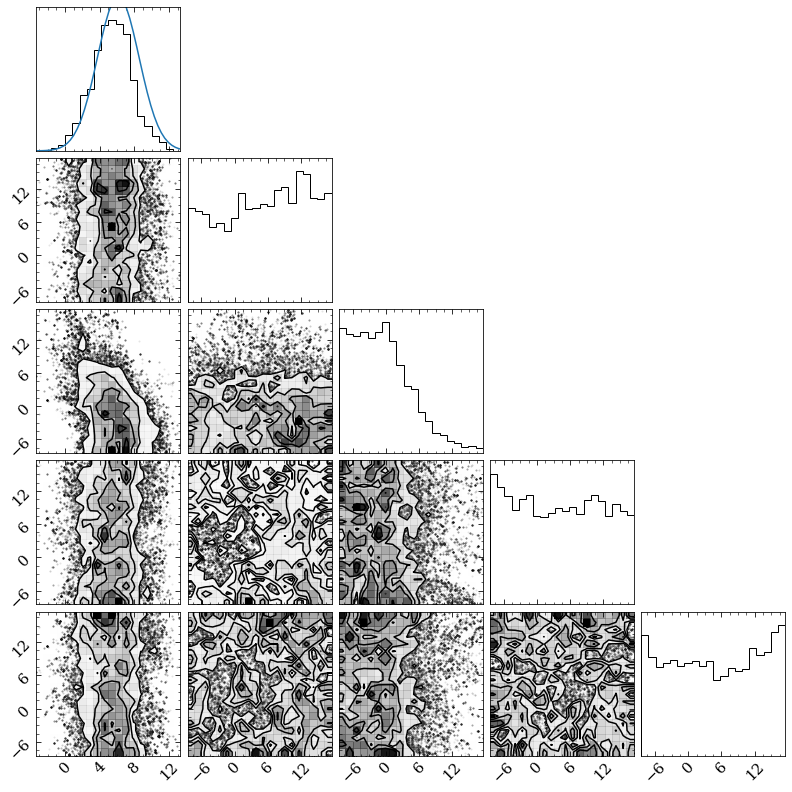

In [ ]:
def make_corner(sampler, labels, minval = 50):
    dim = sampler.chain.shape[-1]
    samples = sampler.chain[:, minval:, :].reshape((-1, dim))
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

def make_corner_vonly(sampler, ndim, labels, minval = -100):
    samples = sampler.chain[:, minval:, :ndim].reshape((-1, ndim))
    print(samples.shape)
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    return fig
    plt.show()

if True:
    for i in range(0, len(sightlines), 4):
        sl_i = sightlines[i]
        ndim = len(sl_i.bins) - 1 
        fig = make_corner_vonly(sl_i.sampler, ndim, labels = None, minval =-200)
        axes = np.array(fig.axes).reshape(ndim, ndim)
        axes[0, 0].plot(priorx, 1e5* prior_for_plot(sl_i.l, sl_i.b, priorx))
        plt.show()

In [ ]:
sl = sightlines[0]
print(sl.stars['DIST'].value)
print(sl.bins)
print(sl.signals.shape)
print(sl.bin_inds)

[525.6187  585.30536 569.88995 418.4891 ]
[  0.      400.01    418.4991  525.6287  569.89996 585.31537]
(4, 95)
[3 5 4 2]


N 0
(4, 95) (4, 5, 95) (4, 5)


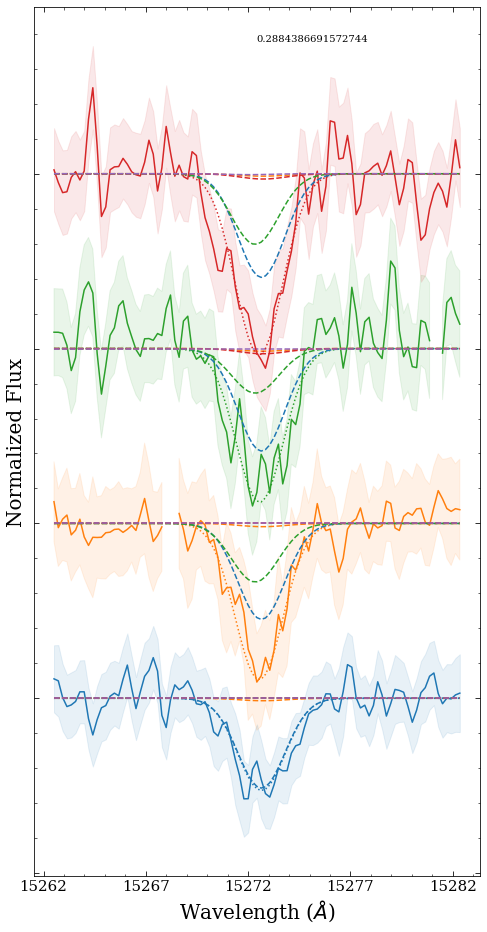

In [ ]:
def model_signals_fg(rvelo, sl, dAVdd):
    # dAVdd = sl.dAVdd
    signals = np.zeros((len(sl.stars), len(wavs_window)))
    unsummed_signals = np.zeros((len(sl.stars), len(sl.bins)-1,len(wavs_window)))
    print(signals.shape, unsummed_signals.shape, sl.dAVdd.shape)
    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(sl.bins) - 1, 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
    amp = differentialAmplitude(dAVdd, sl.bins[1:]-sl.bins[:-1])

    def single_signal(amp, bindex):
        amp[bindex:] = 0 # THIS MIGHT NEED TO BE -1
        # print(amp)

        voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        # continuum = lambda x, m, b : m * (x - lambda0) + b
        # cont = continuum(wavs_window, 0, b)
        return summed_DIB  + 1, voxel_DIB_scaled 


    for i in range(len(sl.stars)):
        star = sl.stars[i]
        dAVdd_star = dAVdd[i, :]
        # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
        amp = differentialAmplitude(dAVdd_star, 1)

        bin_index = sl.bin_inds[i]
        # signals[i, :] = single_signal(bin_index)
        signals[i, :], unsummed_signals[i, :, :] = single_signal(amp, bin_index)

    return signals, unsummed_signals

def plot_DIBS_fg(sampler, sl, plot_objs = None, bestprob = True):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, :, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[-100:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)

    ## NEW THING
    if bestprob:
        lp = sl_i.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_fg(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * i,
                         sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * i, color = 'C{}'.format(i), alpha = 0.1)

        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    # ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    # ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_xticks(np.linspace(15272-10, 15272 + 10, 5))

    ax.set_yticklabels('')

    return signal_recreated, sl.signals, sl.signal_errs

chi2s = np.zeros(len(sightlines))
sl_lensignals = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    print('N', i)
    fig, ax = plt.subplots(figsize = (8, 16))

    sl_i = sightlines[i]
    sl_lensignals[i] = sl_i.nsig
    sampler_i = sl_i.sampler
    reproducedDIBs, realDIBs, realDIBerrs = plot_DIBS_fg(sampler_i, sl_i, plot_objs = (fig, ax))

    chi2 = np.nansum((realDIBs-reproducedDIBs)**2 / realDIBerrs**2) / np.sum(np.isnan(realDIBs) == False)
    chi2s[i] = chi2

    ymin, ymax = ax.get_ylim()
    ax.text(lambda0, ymax - .01, str(chi2))

    lp_i = sampler_i.lnprobability
    lp_med_i = np.nanmedian(lp_i[:, -100:])
    # ax.text(lambda0, ymax - .01, 'sl index {}'.format(i) )
    # ax.text(lambda0, ymax - .015, 'lnprob {}'.format(lp_med_i) )

    name_i = 'dibs_' + str(i)
    # fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/231015_DIBmodels/{}.png'.format(name_i), overwrite = True)

    plt.show()




In [ ]:
# add CO profile to y axis of v vs d plots 
# also add prior as errorbar or something
# consider propogating uncertainty more
# how many stars have high-latitude low-extinction twins
# teff, logg, m_h, alpha_fe, SNR

In [ ]:
sl_davdd = np.zeros((len(l_sample.flatten()), dust_data.dustmap.shape[-1]))
for i in range(len(l_sample.flatten())): 
    l_i, b_i = l_sample.flatten()[i], b_sample.flatten()[i]
    l_ind, b_ind = find_nearest(l_i, b_i)
    sl_davdd[i, :] = np.copy(dust_data.dustmap[b_ind, l_ind, :])

In [ ]:
def plot_velo(sampler, sl , min_walker = None, plot_objs = None, color = None, plot_lines = False, plot_box = False, plot_violin = False, bestprob = False,):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8,6))
    else:
        fig, ax = plot_objs
    ndim = len(sl.voxel_dAVdd)

    walker_max = sampler.chain.shape[1]

    if min_walker is None:
        min_walker_val = -100
    # else:
    min_walker_val = walker_max - min_walker

    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))

    vel_samples = samples[:, :sl.ndim]
    avg_av = np.nansum(np.median(sl.dAVdd, axis = 0))

    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    if bestprob:
        lp = sl_i.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]


    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    perc16, perc50,  perc84 = (np.percentile(samples[min_walker_val:, :], 16, axis = 0), 
                               np.percentile(samples[min_walker_val:, :], 50, axis = 0),
                               np.percentile(samples[min_walker_val:, :], 84, axis = 0) )
    velo16, velo50, velo84 = (perc16[:ndim], perc50[:ndim], perc84[:ndim])

    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)


    # ax.scatter((a.bins[1:] + a.bins[:-1] ) /2 , med_velo)
    # if
    # for i in range(len(sl.bins)-1): 
    #     ax.hlines(med_velo[i], sl.bins[i], sl.bins[i+1], linestyle = 'dashed')
    #     if i < len(sl.bins) -2:
    #         ax.vlines(sl.bins[i+1], med_velo[i], med_velo[i+1], linestyle = 'dashed')

    if color == None:
        color_choice = 'k'
    else:
        color_choice = color
    

    if plot_box:
        # ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'dashed', linewidth = 0.5)
        # ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = color_choice)
        ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = 'k')


        for j in range(len(sl.bins)-1):
            # ax.fill_between([sl.bins[i], sl.bins[i +1]], med_velo[i]+std_velo[i], med_velo[i]-std_velo[i], 
            #                 alpha = 0.3, color = color_choice, hatch = '/')
            ax.fill_between([sl.bins[j], sl.bins[j +1]], velo84[j], velo16[j], 
                    alpha = 0.3, color = 'C{}'.format(j))

    axmin = 350
    if plot_violin:
        bin_pos = sl.bins[:]
        bin_pos[0] = axmin
        pos = (bin_pos[1:] + bin_pos[:-1])/2
        
        w = (bin_pos[1:] - bin_pos[:-1])
        ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=False)



    # else:  
    #     # ax.errorbar((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    #     # ax.scatter((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, c = color_choice)
    #     ax.errorbar((sl.bins[1:] ) , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    #     ax.scatter((sl.bins[1:] ) , med_velo, c = color_choice)
    #     if plot_lines:
    #         ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'solid', linewidth = .5)



    # ax.errorbar((sl.bins[1:]),med_velo, xerr = (sl.bins[1:] - sl.bins[:-1], np.zeros(med_velo.shape)), yerr = std_velo, fmt = '.' )
    ax.set_xlim(axmin, 600)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

    dist_xx = (sl.bins[1:] + sl.bins[:-1] ) /2
    # med_velo

    return fig, ax, dist_xx, med_velo, std_velo


In [ ]:
# def polynomial2d( x1, x2, theta = None, uncert = None):  
#         if theta is None:
#             theta = np.array([5.03964666, -1.04129592, -0.72842925, -0.20292219,  0.0206567,  -0.14442016])
#         if uncert is None:
#             uncert = 2.404363059339516
#         if np.array(x1).ndim != 1:
#             x1 = np.array([x1])
#             x2 = np.array([x2])
#         x1 = x1 - 160 # FOR CA CLOUD SPECIFICIALLY
#         x2 = x2 + 8 # DITTO
#         X = np.array([[np.ones(np.array(x1).shape), x1, x2, x1 * x2, x1**2, x2**2]]).T
#         matrix = X * theta[:, np.newaxis]
#         print(matrix.shape)
#         return np.nansum(matrix, axis = 1).flatten()

# def box(x, min = -8.5, max = 17.5):
#      y = np.ones(len(x))
#      y[x < min] = 0
#      y[x > max] = 0
#      return y

# def prior_for_plot(l, b, x ):
#     gaussn = lambda x, mu, sig : 1/(np.sqrt(2 * np.pi) * sig) * np.exp(-(x - mu)**2 / (2 * sig**2))     
#     # x = np.linspace(-20, 20, 100)
#     sig =  2.404363059339516
#     mu = polynomial2d(l, b)
#     print(mu)
#     return gaussn(x, mu, sig) #* box(x)
    

N  0
[375.00500488 409.25457764 472.06390381 547.76434326 577.60766602]
[ 4.51254878  5.82108389 -1.50076266  6.21736887 -7.23837575]
[409.25457764 472.06390381 547.76434326 577.60766602]
(array([-0.03728332, 18.9290433 ]), array([[ 2.80682180e-03, -1.38227178e+00],
       [-1.38227178e+00,  6.90665237e+02]]))
(1, 6, 1)
[6.14218021]


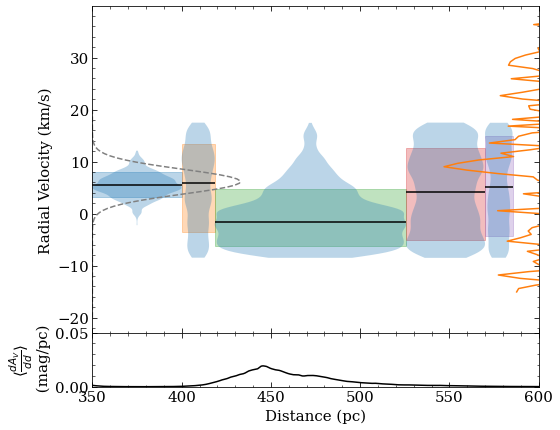

In [ ]:
avs = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    avs[i] = np.sum(sl_i.voxel_dAVdd)

line = lambda x, m, b : m * x + b

cnorm = matplotlib.colors.Normalize(np.min(avs), np.max(avs))
cmap = plt.get_cmap('viridis')
mappable = matplotlib.cm.ScalarMappable(norm = cnorm,  cmap = cmap)


sightlines_slopes = np.zeros(len(sightlines))
sightlines_slopes_err = np.zeros(len(sightlines))


dist_xx_sl = np.array([])
velo_yy_sl = np.array([])
std_velo_sl = np.array([])

priorx = np.linspace(-20, 20, 100)

# for i in range(len(sightlines)): 
for i in range(0, len(sightlines), 10): 

    print('N ', i)
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,7), sharex = True, gridspec_kw={'height_ratios': [6,1], 'hspace': 0})

    

    dist_xx = np.array([])
    velo_yy = np.array([])
    std_velo = np.array([])
    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    color = cmap(cnorm(avs[i]))
    color = 'C'+str(i)
    _, __, dist_xx_i, velo_yy_i, std_velo_i = plot_velo(sampler_i, sl = sl_i, min_walker = 10, plot_objs = (fig, axs[0]), color = color, 
                                                        plot_box = True, plot_violin=True, bestprob = True)
    dist_xx = np.concatenate([dist_xx, dist_xx_i])
    velo_yy = np.concatenate([velo_yy, velo_yy_i])
    std_velo = np.concatenate([std_velo, std_velo_i])

    print(dist_xx)
    print(velo_yy)

    dist_sort = np.argsort(dist_xx)
    # print(dist_sort)

    try:
        filt = (dist_xx[dist_sort] > 400) & (dist_xx[dist_sort] <= 800)
        print(dist_xx[dist_sort][filt])
        fit_result = curve_fit(line, dist_xx[dist_sort][filt], velo_yy[dist_sort][filt], sigma = std_velo[dist_sort][filt])
        print(fit_result)
        fit_params = fit_result[0]
        fit_result_err = np.sqrt(np.diag(fit_result[1]))
        xx_plot = np.linspace(380, 600)

        # axs[0].plot(xx_plot, line(xx_plot, fit_params[0], fit_params[1]), label = 'SL ' + str(i))
        sightlines_slopes[i] = fit_params[0] 
        sightlines_slopes_err[i] = fit_result_err[0]
    except Exception as e:
        print('didn\'t fit properly')
        print(e)
        sightlines_slopes[i] = np.nan

    ### ADDDED 03.28 ###
    fgprior = prior_for_plot(sl_i.l, sl_i.b, priorx)
    axs[0].plot(5e2 * fgprior + 350, priorx, color = 'grey', linestyle = 'dashed')

    ### ADDED 03.31 ###
    profile, rvel = get_CO_profile(sl_i.l, sl_i.b)
    axs[0].plot(600- 5e1*profile, rvel)

    axs[1].plot(dust_data.distance, sl_davdd[i, :], color = 'k')
    # ax.set_ylim(ymin, ymax)
    axs[1].set_xlim(350, 600)
    axs[1].set_xlabel('Distance (pc)')
    axs[1].set_ylabel(r'$ \langle \frac{dA_V}{dd} \rangle $' + '\n (mag/pc)')
    axs[1].set_ylim(0, 0.05)
    fig.set_facecolor('white')

    # for j in range(len(sl_i.stars)):
    #     axs[1].scatter(sl_i.stars['DIST'][j], sl_davdd[i, find_nearest_dist(sl_i.stars['DIST'][j])])

    # axs[0].legend()
    # name_i = 'veldist_' + str(i)
    # fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )

    plt.show()

    dist_xx_sl = np.concatenate([dist_xx_sl, dist_xx])
    velo_yy_sl = np.concatenate([velo_yy_sl, velo_yy])
    std_velo_sl = np.concatenate([std_velo_sl, std_velo])

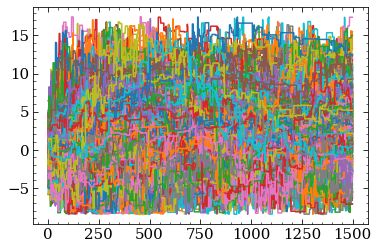

In [ ]:
plt.plot(sightlines[0].sampler.chain[:, :, 0].T)

In [ ]:
start = 0
stop = len(sightlines)

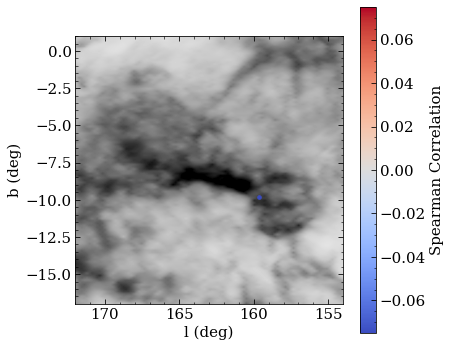

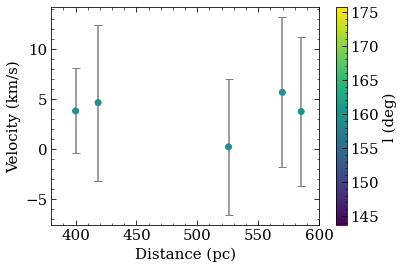

In [ ]:
from scipy.stats import spearmanr
def gradientmetric_deriv(array, dist):    
    a, b = np.meshgrid(array, array)
    c, d = np.meshgrid(dist, dist)
    grad_matrix = np.triu(b - a)
    deltadist = np.triu(d - c)
    nz = grad_matrix != 0
    grad_matrix[nz] = grad_matrix[nz] / deltadist[nz]
    shape = grad_matrix.shape[0]
    return np.sum(grad_matrix) / (0.5 * shape * (shape - 1))

sl_metrics = np.zeros(len(sightlines))
sl_spearman = np.zeros((len(sightlines), 2))


v_all = np.array([], dtype = float)
verr_all = np.array([], dtype = float)
d_all = np.array([], dtype = float)
l_sightline = np.array([], dtype = float)
sl_counts = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    ndim = len(sl_i.voxel_dAVdd)
    walker_max = sl_i.sampler.chain.shape[1]
    min_walker_val = walker_max - 100
    sampler = sl_i.sampler
    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))
    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]
    bin_dist = sl_i.bins[1:]

    select_cloud = bin_dist > 400


    metric = np.sum(gradientmetric_deriv(med_velo[select_cloud], bin_dist[select_cloud]))
    sl_metrics[i] = metric

    spearman_correlation = spearmanr(bin_dist[select_cloud], med_velo[select_cloud])
    sl_spearman[i, 0] = spearman_correlation.correlation
    sl_spearman[i, 1] = spearman_correlation.pvalue

    v_all = np.concatenate([v_all,med_velo])
    verr_all = np.concatenate([verr_all, std_velo]) 
    d_all = np.concatenate([d_all, bin_dist])

    l_sightline = np.concatenate([l_sightline, l_sample[i] * np.ones(len(med_velo))])
    sl_counts[i] = len(med_velo)
# fig, ax = plt.subplots(figsize = (6,6))
# im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
# # masks = (np.nansum(edenhofer, axis = 2) >= 2.2).astype(float)
# # masks_3 = (np.nansum(edenhofer, axis = 2) < 1.5).astype(float)
# # im_mask = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Reds', alpha = masks, extent = (l0-9, l0+9, b0-9, b0+9))
# # im_mask_3 = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Purples', alpha = masks_3, extent = (l0-9, l0+9, b0-9, b0+9))
# points = ax.scatter(l_sample[:17], b_sample[:17], c = sightlines_slopes[:], vmin = -0.15, vmax = 0.15, cmap = 'coolwarm')
# ax.set_xlabel('l (deg)')
# ax.set_ylabel('b (deg)')
# xmin, xmax = ax.get_xlim()
# ax.set_xlim(xmax, xmin)
# # fig.colorbar(im, label = "A(V)")
# fig.colorbar(points, label = 'Slope (km/s / pc)')
# plt.show()


# fig, ax = plt.subplots(figsize = (6,6))
# im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
# # masks = (np.nansum(edenhofer, axis = 2) >= 2.2).astype(float)
# # masks_3 = (np.nansum(edenhofer, axis = 2) < 1.5).astype(float)
# # im_mask = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Reds', alpha = masks, extent = (l0-9, l0+9, b0-9, b0+9))
# # im_mask_3 = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Purples', alpha = masks_3, extent = (l0-9, l0+9, b0-9, b0+9))
# points = ax.scatter(l_sample[:17], b_sample[:17], c = sl_metrics[:], vmin = -0.075, vmax = 0.075, cmap = 'coolwarm')
# ax.set_xlabel('l (deg)')
# ax.set_ylabel('b (deg)')
# xmin, xmax = ax.get_xlim()
# ax.set_xlim(xmax, xmin)
# # fig.colorbar(im, label = "A(V)")
# fig.colorbar(points, label = 'Metric')
# plt.show()

fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
# masks = (np.nansum(edenhofer, axis = 2) >= 2.2).astype(float)
# masks_3 = (np.nansum(edenhofer, axis = 2) < 1.5).astype(float)
# im_mask = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Reds', alpha = masks, extent = (l0-9, l0+9, b0-9, b0+9))
# im_mask_3 = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Purples', alpha = masks_3, extent = (l0-9, l0+9, b0-9, b0+9))
points = ax.scatter(l_sample[:stop], b_sample[:stop], c = sl_spearman[:, 0], s= 100 * (1-sl_spearman[:, 1]), vmin = -0.075, vmax = 0.075, cmap = 'coolwarm')
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmax, xmin)
# fig.colorbar(im, label = "A(V)")
fig.colorbar(points, label = 'Spearman Correlation')
plt.show()

sl_spearman.astype(np.float16)
fig, ax = plt.subplots()
fil = np.nansum(crit_filament)
fil_idx = np.sum(sl_counts[:fil]).astype(int)
start = 0
stop = None
ax.errorbar(d_all[start:stop], v_all[start:stop], yerr = verr_all[start:stop], fmt = '.', capsize = 4, color = 'grey')

points = ax.scatter(d_all[start:stop], v_all[start:stop], c = l_sightline[start:stop], zorder = 5, )

ax.set_xlim(380, 600)
ax.set_xlabel('Distance (pc)')
ax.set_ylabel('Velocity (km/s)')
fig.colorbar(points, label = 'l (deg)')
plt.show()

In [ ]:
# def polynomial2d(x1, x2, theta = None, uncert = None):  
#     if theta is None:
#         theta = np.array([5.03964666, -1.04129592, -0.72842925, -0.20292219,  0.0206567,  -0.14442016])
#     if uncert is None:
#         uncert = 2.404363059339516
#     x1 = x1 - 160 # FOR CA CLOUD SPECIFICIALLY
#     x2 = x2 + 8 # DITTO
#     X = np.array([[np.ones(np.array(x1).shape), x1, x2, x1 * x2, x1**2, x2**2]]).T
#     matrix = X * theta[:, np.newaxis]
#     return np.nansum(matrix, axis = 1)

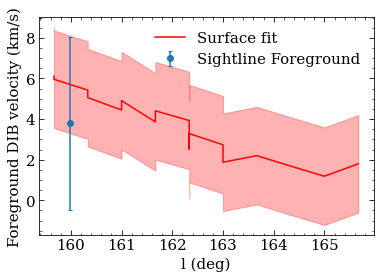

In [ ]:
selectfg = np.abs(d_all - 400) < 5
fig, ax = plt.subplots()
ax.errorbar(l_sample[0] + 0.5 * np.random.random(np.sum(selectfg)), v_all[selectfg], yerr = verr_all[selectfg], fmt = 'o', capsize = 2, label = 'Sightline Foreground')
lx, bx = l_sample[:17], b_sample[:17]
xsort = np.argsort(lx)
y = polynomial2d(lx[xsort], bx[xsort]).flatten()
ax.plot(lx[xsort], y, color = 'r', label = 'Surface fit')
ax.fill_between(lx[xsort], y + 2.404363059339516, y - 2.404363059339516, color = 'r', alpha = 0.3)
ax.set_xlabel('l (deg)')
ax.set_ylabel('Foreground DIB velocity (km/s)')
ax.legend()

In [ ]:
v_all

array([3.80023749, 4.63259059, 0.19789644, 5.66313981, 3.74427653])

In [ ]:
y

array([6.1150739 , 5.96338854, 5.42701963, 5.05677316, 4.44857812,
       4.90901224, 3.85874459, 4.40936635, 3.92808197, 2.5180897 ,
       3.28727258, 2.73416207, 1.87479156, 2.19941308, 1.68302559,
       1.18499962, 1.79708275])